<a href="https://colab.research.google.com/github/jamg-upv/Impacto-citas-articulo/blob/main/impactoencitas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How to cite this work:



------------
Referencias: 
Documento compartidoen drive

Miro: https://miro.com/app/board/uXjVOVj0st4=/?moveToWidget=3458764518530820364&cot=14

Este codigo permite integrar una tabla con los datos de un conjunto de articulos y sus numeros de citas, normalizarlas teniendo en cuenta las tablas de citas mundiales (scopus) o baseline de (WOS), y añadir las métricas de impacto de la revista en el año de publicación del articulo.
Son necesarias 3 tablas para cada proveedor (scopus y WOS)


Fuente de datos SCOPUS https://elsevier.com/?a=734751


Tareas 
1. Lista de 25 DOIs Banco de Pruebas1  (meritos (5 autores "al azar") )
2. Descargar como cvs bancopruebas1sco tabla Scopus  de 25 meritos (5 autores "al azar") a partir de los DOI
1. Descargar como cvs bancopruebas1wos tabla WOS de los 25 meritos a partir de los DOI
1. preparar un prototipo de la tabla que penamos crear para consultar a compañeros del equipo
2.   



Pasos previos. Librerias y configuración

In [1]:
# Importamos ls librería de Python que necesitaremos en este notebook

import pandas as pd  # Pandas permite manipular tablas 
import matplotlib.pyplot as plt  # Para hacer gráficas
import seaborn as sns  # Para hacer gráficas pero necesita matplotlib y deja unos graficos chulisismos 
sns.set_style('whitegrid')  # Pone una malla de fondo bastante mona para Seaborn
import numpy as np

import os #rename files
#import xlwings as xw #permite leer docuemtnos xlb me da error y no lo puedo instalar

# Redondeamos las salidas a dos decimales
%precision %.2f

# from google.colab import drive
# drive.mount('/content/drive')



'%.2f'

Carga de *datos* Indicadores de revistas SCOPUS

In [4]:
#métricas de revistas Scopus
# si lo descargamos directo de la web Ç(ventaja es que con una descarga siempre está accesible y no hay que volver a descargarlo durante la sesión)
# el archivo de SCopus de 10 años ocupa demasiados GB (60gb) y no se puede alojar en drive (no debería esar en un acceso libre en github porque es propiedad de Scopus)
   #!wget https://elsevier.com/?a=734751 
#es XLB, hay que convertirlo a mano XLS porque xlb requiere de librerias que no tengo instaladas en colab
# y hacerlo accesible aquí
#la primer pesaña son definiciones de indicadores, la segunda el el año más reciente y luego 9 mas con los anteriores. La ultima pestaña es un clasificación de categorias
## depricated_Puedo limpiar a mano las pestañas no usadas (priemera y ultima) y dejo solo los 7 años más recientes (para que sean solo 44mb y me quepa en google drive)--> pero no sirve porque luego no lee bien porque googledrive CONVIERTE a formato propio

# abro el xlb a mano y lo convierto en Excel, Aprovecho para Preparacion de las pestañas d la excel quitando espacioes en los rotulos del encabezado Estandarizar los nombres de las columnas
# ScopusSourceID Title CitationCount ScholarlyOutput PercentCited CiteScore SNIP SJR ScopusASJCCode 
# ScopusSubSubjectArea Percentile RANK RankOutOf Publisher Type OpenAccess Quartile Top10 
# URLScopusSourceID PrintISSN ElectISSN
# Subo a Alfresco (que permite leerlo como un xls)

# descarga de alfresco con el nombre de fichero que quiera guardarlo
!wget --output-document=CiteScore14_20.xlsx https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/egXj6G-GT0WY_g3O-2_swA
#si lo hago manual, que tarda varios minutos en subir cada vez) con Wget en pocos segundos está cargado en el entonrno

# en general funciona mejor con archivos csv, que con excel. tendre que partir el archivo excel en csv

#renbombrar el fichero local descargado para que no sea tan feote
#os.rename(r'/content/edit?usp=sharing',r'/content/scopus.xlsx')

--2022-02-10 17:37:12--  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/egXj6G-GT0WY_g3O-2_swA
Resolving gdocu.upv.es (gdocu.upv.es)... 158.42.4.31
Connecting to gdocu.upv.es (gdocu.upv.es)|158.42.4.31|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 62207801 (59M) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘CiteScore14_20.xlsx’

CiteScore14_20.xlsx 100%[===================>]  59.33M  6.44MB/s    in 15s     

2022-02-10 17:37:27 (4.07 MB/s) - ‘CiteScore14_20.xlsx’ saved [62207801/62207801]



In [ ]:
# unos 150seg en cargar el dataframe)
# me sirve para comprobar el tamaño de filas en cada conjunto de años con los que tengo en el CVS (o puedo directamente trabajar con este dataframe)

dfs = pd.read_excel('/content/CiteScore14_20.xlsx',engine='openpyxl',sheet_name=None)
dfs

In [ ]:
# Otra forma de hacer exactamente lo mismo de arriba (130 segundo) (puede llegar a 180seg)
# creo un objeto tipo DICT

xl_file = pd.ExcelFile('/content/CiteScore14_20.xlsx')

dfs2 = {sheet_name: xl_file.parse(sheet_name) 
          for sheet_name in xl_file.sheet_names}
dfs2

In [8]:
##pendiente automtizar la creación de un CSV a partir de las pestañas, añadiendo una columna del año (y rotulando citescore solo sin años en las columnas de datos)

Preparacion de las pestañas d la excel
Quitar espacioes en los rotulos del encabezado
Estandarizar los nombres de las columnas

ScopusSourceID	Title	CitationCount	ScholarlyOutput	PercentCited	CiteScore	SNIP	SJR	ScopusASJCCode	ScopusSubSubjectArea	Percentile	RANK	RankOutOf	Publisher	Type	OpenAccess	Quartile	Top10	URLScopusSourceID	PrintISSN	ElectISSN


In [ ]:
# importar tablas de metricas revisas SCOPUS (la excel original la he convertido en un CVS por cada pestaña)
# hay que importar los csv y ñadir a cada uno un campo con el año y luego fusionarlos en una tabla unica o trabajarlos como tablas separadas (no sé que será más eficiente)
# El csv subido a Github no funciona (crea tags de html en el archivo y no se lee luego con pandas. Lo lee pero los nombres de los ficheros no son intuitivos)
# !wget https://github.com/jamg-upv/Impacto-citas-articulo/blob/main/tablasinput/CiteScore2020.csv


--2022-02-08 20:00:51--  https://github.com/jamg-upv/Impacto-citas-articulo/blob/main/tablasinput/CiteScore2020.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘CiteScore2020.csv’

CiteScore2020.csv       [ <=>                ] 169.11K  --.-KB/s    in 0.04s   

2022-02-08 20:00:51 (4.28 MB/s) - ‘CiteScore2020.csv’ saved [173167]



In [ ]:
#lecturas en orden inverso de 2020 hasta 2011
!wget --output-document=CS2020.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/bCd_63LrSVSkf96qwXihVQ  #2020
!wget --output-document=CS2019.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/5XemCCZCS-WNmJ-byA6uzA #2019
!wget --output-document=CS2018.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/H3ZrGBF1TNuBDCI95AVHkA #2018
!wget --output-document=CS2017.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/kTZ3Mlj8Qr6DC08kauJ2og #2017
!wget --output-document=CS2016.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/N3l6wTevTLeD6fgI42Hlvw #2016
!wget --output-document=CS2015.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/oYOpp1OcTIKXBzXfsDuf2g  #2015
!wget --output-document=CS2014.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/FMHpXVs4SXygTdZGYVp1kA #2014
!wget --output-document=CS2013.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/XOSnXVhMSFG3lC3hg8bHmg #2013
!wget --output-document=CS2012.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/IE_0VEppTFOxR2MEwMy9Nw #2012
!wget --output-document=CS2011.cvs  https://gdocu.upv.es/share/proxy/alfresco-noauth/api/internal/shared/node/content/Q_O9A4pMTmaXZmxdEaMmSw #2011

In [3]:
CS2020= pd.read_csv('CS2020.cvs',sep=';')
CS2019= pd.read_csv('CS2019.cvs',sep=';')
CS2018= pd.read_csv('CS2018.cvs',sep=';')
CS2017= pd.read_csv('CS2017.cvs',sep=';')
CS2016= pd.read_csv('CS2016.cvs',sep=';')
CS2015= pd.read_csv('CS2015.cvs',sep=';')
CS2014= pd.read_csv('CS2014.cvs',sep=';')
CS2013= pd.read_csv('CS2013.cvs',sep=';')
CS2012= pd.read_csv('CS2012.cvs',sep=';')
CS2011= pd.read_csv('CS2011.cvs',sep=';')
#puedo empaquetar los diferentes dataframes juntos para hacer referencia a ellos con un índice
ListOfYearCS=[CS2020,CS2019,CS2018,CS2017,CS2016,CS2015,CS2014,CS2013,CS2012,CS2011]

In [ ]:
CS2020

,ScopusSourceID,Title,CitationCount,ScholarlyOutput,PercentCited,CiteScore,SNIP,SJR,ScopusASJCCode,ScopusSubSubjectArea,Percentile,RANK,RankOutOf,Publisher,Type,OpenAccess,Quartile,Top10,URLScopusSourceID,PrintISSN,ElectISSN
0,21101021140,1700-tal: Nordic Journal for Eighteenth-Centur...,0,5,0,0,0,0,1213,Visual Arts and Performing Arts,6,466,532,Swedish Society for Eighteenth-Century Studies,j,YES,4,FALSO,https://www.scopus.com/sourceid/21101021140,NaN,NaN
1,21101021140,1700-tal: Nordic Journal for Eighteenth-Centur...,0,5,0,0,0,0,1202,History,3,1235,1328,Swedish Society for Eighteenth-Century Studies,j,YES,4,FALSO,https://www.scopus.com/sourceid/21101021140,NaN,NaN
2,21101021140,1700-tal: Nordic Journal for Eighteenth-Centur...,0,5,0,0,0,0,3316,Cultural Studies,2,986,1037,Swedish Society for Eighteenth-Century Studies,j,YES,4,FALSO,https://www.scopus.com/sourceid/21101021140,NaN,NaN
3,21100404576,2D Materials,12778,920,90,"13,9","1,402","2,702",2210,Mechanical Engineering,97,14,596,Institute of Physics Publishing,j,NO,1,VERDADERO,https://www.scopus.com/sourceid/21100404576,NaN,20531583
4,21100404576,2D Materials,12778,920,90,"13,9","1,402","2,702",2211,Mechanics of Materials,97,11,377,Institute of Physics Publishing,j,NO,1,VERDADERO,https://www.scopus.com/sourceid/21100404576,NaN,20531583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59339,28883,Zygon,301,237,56,"1,3","0,853","0,222",3304,Education,46,707,1319,Wiley-Blackwell,j,NO,3,FALSO,https://www.scopus.com/sourceid/28883,5912385,14679744
59340,19073,Zygote,588,206,69,"2,9","0,559","0,416",1309,Developmental Biology,25,61,81,Cambridge University Press,j,NO,3,FALSO,https://www.scopus.com/sourceid/19073,9671994,14698730
59341,19073,Zygote,588,206,69,"2,9","0,559","0,416",1307,Cell Biology,22,218,279,Cambridge University Press,j,NO,4,FALSO,https://www.scopus.com/sourceid/19073,9671994,14698730
59342,19700173167,Zywnosc. Nauka. Technologia. Jakosc/Food. Scie...,111,191,32,"0,6","0,279","0,149",2209,Industrial and Manufacturing Engineering,23,259,336,Polish Society of Food Technologists,j,NO,4,FALSO,https://www.scopus.com/sourceid/19700173167,14256959,NaN


In [ ]:
CS2019

In [ ]:
CS2018

In [ ]:
CS2017

In [ ]:
CS2016

In [ ]:
CS2015

In [ ]:
CS2014

In [ ]:
CS2013

In [ ]:
CS2012

In [ ]:
CS2011

Para cada año dejar solo la fila donde una revista tenga el mejor CS (igual no es la fila con el mejor percentil de SJR pero como no tengo percentilizado el SJR no me afecta (puedo "percentilizarlo" con las revistas incluidas en las solicitudes de años anteriores

(array([8424., 8138., 4931., 2327., 1301.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

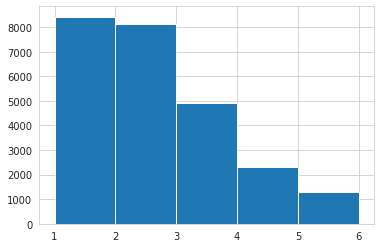

In [32]:
#para cada año 
df=ListOfYearCS[1]
# Tabla con todos los ISSN Repetidos en un año (o ScopusSourceID sería más robusto o más rápido porque no tengo que ver en qué columna mirar) contar>1
#crear una columna para el count
#dos formas de hacer lo mismo
#as index false es vital para que no cree una serie sino un dataframe donde pueda apuntar a las variables https://realpython.com/pandas-groupby/
ContarSourceId=df.groupby(['ScopusSourceID'], as_index=False).size()
ContarSourceId

ContarSourceId2 = df.groupby("ScopusSourceID", as_index=False).size()
ContarSourceId2

plt.hist(ContarSourceId2 ["size"], bins=[1,2,3,4,5,6])
# plt.hist(ContarSourceId2 ["size"], bins=6)

In [ ]:
# # Para convertir el indice de una tabla en una columna de un df
# s.index.name = 'Date'
# s.reset_index()

# # Pero no lo necesito porque uso "as index false" para que no cree una serie sino un dataframe donde pueda apuntar a las variables https://realpython.com/pandas-groupby/
# total=filtered_dates.groupby(['provincia_iso'], as_index=False).agg(sum)


In [ ]:
# en lugar de mostrar solo las filas cuyo count sea mayor que 1 y  buscar las filas con el ScopusSourceID	 >1  y borrar las filas de menos Percentile
# aprovecho la función keep="last" para  eliminar todas las filas con un valor repetido, menos la ultima
# Establecemos keep=False para eliminar todas las filas que tengan el mismo valor de cualquier columna.

#primero tengo que ordenar por ScopusSourceID  y por 
df_without_duplicates = df_with_duplicates.drop_duplicates(
    subset=['Name'], keep="last")



In [ ]:
# compruebo que ahora no hay ScopusSourceID repetidos

set() para eliminar los duplicados en una lista en Python

Queremos contar el número de códigos que utiliza un país. A continuación se enumeran las diferentes formas de contar los valores únicos.

df.groupby().nunique() Método

df.groupby().agg() Método

df.groupby().unique() Método


df = pd.DataFrame(data, columns=["code","Countries"])
result = df.groupby('Countries')['code'].nunique()
print(result)

Este método es útil cuando se quiere ver qué país está usando qué códigos.
result = df.groupby('Countries')["code"].unique()
print(result)


my_list.remove(2) # [5, 'DevCode', 1.2, 5]
En este ejemplo estamos removiendo el elemento 2, de la lista que tiene por nombre "my_list".

Aquí, pasamos Name como argumento subset al método drop_duplicates(). Las filas cuarta y quinta son eliminadas ya que tienen el mismo valor de la columna Name que la primera columna.
df_with_duplicates = pd.DataFrame({
    'Id': [302, 504, 708, 103, 303, 302],
    'Name': ['Watch', 'Camera', 'Phone', 'Shoes', 'Watch', 'Watch'],
    'Cost': ["300", "400", "350", "100", "300", "300"]
})

df_without_duplicates = df_with_duplicates.drop_duplicates(subset=['Name'])
print("DataFrame with duplicates:")
print(df_with_duplicates, "\n")
print("DataFrame without duplicates:")
print(df_without_duplicates, "\n")

Elimina todas las filas excepto la última que tiene el mismo valor de la columna Name.

Establecemos keep=False para eliminar todas las filas que tengan el mismo valor de cualquier columna.
df_without_duplicates = df_with_duplicates.drop_duplicates(
    subset=['Name'], keep="last")

print("DataFrame with duplicates:")
print(df_with_duplicates, "\n")
print("DataFrame without duplicates:")
print(df_without_duplicates, "\n")
df_without_duplicates = df_with_duplicates.drop_duplicates(
    subset=['Name'], keep=False)


In [ ]:

start_date = '2020-09-01'
end_date = '2021-03-24'
after_start_date = data['fecha'] >= start_date
before_end_date = data['fecha'] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = data.loc[between_two_dates]
# .loc 
filtered_dates

# and OR
data2 = data[(data['provincia_iso'] =='V') | (data['provincia_iso'] =='A')| (data['provincia_iso'] =='CS')]
data2 = data2[(data['sexo'] =='H') | (data['sexo'] =='M')]
data2

In [ ]:
df.groupby(['A','B']).B.agg('count').to_frame('c').reset_index()


In [ ]:
#  ENLAZAR tabla de meritos con metrica de revista por ISSN (ojo que hay que mirar en dos columnas, si no está en PrintISSN	 busco en ElectISSN